In [116]:
### REMOVE THIS ###

client_id = '9f34a1e09fd78fe'
client_secret = 'e5b4803ba0a010191e3b79143de418cf44949d89'

In [117]:
from collections import namedtuple
Item = namedtuple('Item', 'url id'.split())

In [118]:
import os

def load_queue(dir):
    def append(q, name, files):
        q += [f for f in files if f.endswith('.png')]
    q = []
    os.path.walk(dir, append , q)
    return q

In [119]:
import requests
from imgurpython import ImgurClient
from io import BytesIO

print 'Fetching urls...'
queue = []

client = ImgurClient(client_id, client_secret)
items = client.gallery()
for item in items:
    if item.is_album:
        for img in client.get_album(item.id).images:
            queue.append(Item(img['link'], img['id']))
    else:
        queue.append(Item(item.link, item.id))
print 'done'
            

Fetching urls...
done


In [121]:
import matplotlib.pyplot as plt

import numpy as np

from PIL import Image
from cStringIO import StringIO

In [122]:
import os

if not os.path.exists('raw'):
    os.mkdir('raw')

for n, item in enumerate(queue, 1):
    print '\rDownloading {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),

    r = requests.get(item.url)
    if not r.ok:
        continue

    i = Image.open(BytesIO(r.content))
    i.save('raw/{}.png'.format(item.id))
    

In [123]:
if not os.path.exists('low'):
    os.mkdir('low')

queue = load_queue('raw')
for n, f in enumerate(queue, 1):
    print '\rConverting {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),
    i = Image.open('raw/{}'.format(f))
    i = i.convert('L', dither=False)
    scale = float(500) / max(i.width, i.height)
    i = i.resize((int(i.width * scale), int(i.height * scale)))
    i.save('low/{}'.format(f))

Converting 100.00% (480 of 480)


In [249]:
from collections import defaultdict
from collections import namedtuple

Directions = namedtuple('Directions', 'down right'.split())

markov = defaultdict(lambda: Directions(defaultdict(int), defaultdict(int)))

In [10]:
import json, os

if os.path.exists('markov.json'):
    with open('markov.json', 'r') as f:
        markov = {int(state): Directions(*[defaultdict(int, {int(new_state): int(probab)
                   for new_state, probab in transition[direction].items()})
                    for direction in 'right down'.split()])
                      for state, transition in json.loads(f.read()).items()}

In [253]:
def learn_from(f):
    img = np.asarray(Image.open('low/{}'.format(f)))
    w, h = img.shape
    for (i, j), px in np.ndenumerate(img):
        if i + 1 < w:
            markov[px].right[img[i+1, j]] += 1
        if j + 1 < h:
            markov[px].down[img[i, j+1]] += 1

queue = load_queue('low')
for n, i in enumerate(queue, 1):
    learn_from(i)
    print '\rLearning {:.2f}% ({} of {})'.format(float(n) * 100 / len (queue), n, len(queue)),

Learning 100.00% (480 of 480)


In [247]:
import json

with open('markov.json', 'w') as f:
    f.write(json.dumps({str(state): {direction: {str(new_state): str(probab)
                         for new_state, probab in getattr(transition, direction).items()}
                            for direction in 'right down'.split()}
                              for state, transition in markov.items()}))

In [14]:
import shutil

print 'Cleaning up'

shutil.rmtree('raw')
shutil.rmtree('low')

Cleaning up


In [15]:
%matplotlib inline

In [301]:
from operator import itemgetter
from collections import OrderedDict

def normalize(transitions):
    m = max(transitions.values())
    probabilities = {state : float(weight) / m for state, weight in transitions.items()}
    
    states, probs = zip(*sorted(probabilities.items(), key=itemgetter(1)))
    slots = np.cumsum(probs)
    normalized = [s / max(slots) for s in slots]
    distribution = OrderedDict(zip(normalized, states))
    return distribution

normalized = {s: Directions(*map(normalize, d)) for s, d in markov.items()} 

In [303]:
def dump(name, transitions):
    for d in 'right down'.split():
        with open(name+'_'+d+'.txt', 'w') as f:
            for px in transitions.keys():
                f.write(str(px) + '->' + ' '.join(map(repr, sorted(getattr(transitions[px], d).items())))+'\n')

dump('markov', markov)
dump('normalized', normalized)

In [257]:
import random

def pick_from(distribution):
    prob = distribution.keys()
    i, bin = random.random(), 0
    
    for s, t in zip(prob, prob[1:]):
        bin = s
        if s >= i:
            break
            
    return distribution[bin]

In [304]:
from itertools import product

matrix = np.zeros((500, 500), np.uint8)
seed =  random.choice(markov.keys()) # seed
matrix[0][0] = seed

for i, j in product(range(499), range(499)):
    px = matrix[i][j]
    matrix[i][j+1] = pick_from(normalized[px].right)
    matrix[i+1][j] = pick_from(normalized[px].down)

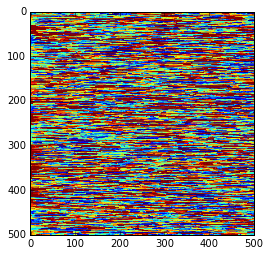

In [305]:
import scipy.misc
scipy.misc.imsave('outfile.jpg', matrix)

plt.imshow(matrix)

In [302]:
' '.join(map(repr, sorted(normalized.keys())))

'0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255'